# **Churn Modeling via Linear Regression.**
Análisis cuantitativo orientado a la modelización del churn (abandono de cliente) a partir de métricas agregadas por índice de precio de venta al público (PVP). El objetivo es estimar la probabilidad de abandono como variable continua mediante regresión lineal, utilizando variables explicativas como la edad media del vehículo, el margen medio por unidad y el kilometraje medio entre revisiones. Los coeficientes del modelo serán empleados posteriormente para estimar la retención individual de clientes y alimentar el cálculo del Customer Lifetime Value (CLTV).

## **Inicialización del entorno y carga de dependencias.**
Conjunto de librerías necesarias para la ejecución del análisis, entre ellas herramientas para manipulación de datos, visualización, conexión con bases de datos relacionales y modelado estadístico. La especificación completa de dependencias se encuentra en el archivo `requirements.txt`.

In [92]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

## **Conexión a la base de datos.**
Interfaz establecida con la base de datos local que contiene el modelo estrella consolidado. Este entorno almacena las tablas de hechos y dimensiones, así como la tabla `features_pvp`, utilizada como dataset base del modelo.

In [93]:
# SQL Server (entorno local)
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'

# Construcción de cadena de conexión
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"
conn = pyodbc.connect(local_conn_str)

### **Ejecución de consulta SQL y construcción del DataFrame.**
Se debe de realizar la lectura desde archivo del script `features_for_regression.sql`, ejecución sobre el motor de base de datos SQL Server y carga del resultado como un DataFrame de Pandas. Este conjunto de datos constituirá la base del modelo de regresión.

In [94]:
# Lectura de la consulta SQL desde archivo
with open("../preprocessing/features_for_regression.sql", "r") as file:
    query = file.read()

# Ejecución de la consulta y carga del resultado en un DataFrame
df = pd.read_sql_query(query, conn)

#### **Recopilación de datos.**
La recopilación de datos es una etapa fundamental en la construcción de cualquier modelo de predicción. En este notebook, aplicaremos técnicas para limpiar y preparar el dataset antes de su uso en el modelado y evaluación en el análisis exploratorio (EDA). Identificaremos la presencia de valores nulos, datos duplicados, variables categóricas y valores atípicos.

In [95]:
df.head()

,PVP,avg_car_age,avg_km_revision,avg_revisiones,churn_percentage
0,21818,1.979167,25912,1,0.125000
1,22814,2.063492,22100,0,0.507937
2,28719,1.666667,14652,1,0.000000
3,31968,3.166667,39917,2,0.166667
4,17550,1.962617,22680,1,0.219626


In [96]:
df.dtypes

PVP                   int64
avg_car_age         float64
avg_km_revision       int64
avg_revisiones        int64
churn_percentage    float64
dtype: object

In [97]:
df.describe()

,PVP,avg_car_age,avg_km_revision,avg_revisiones,churn_percentage
count,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,24063.444115,2.027034,20639.335312,0.751731,0.244651
std,5889.838997,0.760508,11384.179809,0.711075,0.225416
min,10528.000000,0.000000,0.000000,0.000000,0.000000
25%,20359.000000,1.756427,14655.500000,0.000000,0.071259
50%,23909.000000,2.030534,22678.000000,1.000000,0.200000
75%,28183.500000,2.295615,27074.500000,1.000000,0.356850
max,37970.000000,5.000000,54916.000000,5.000000,1.000000


In [98]:
df.isnull().sum() # Valores nulos.

PVP                 0
avg_car_age         0
avg_km_revision     0
avg_revisiones      0
churn_percentage    0
dtype: int64

In [99]:
df.duplicated().sum() # Valores duplicados.

np.int64(0)

## **EDA: Análisis exploratorio de datos.**
Exploración preliminar de la estructura del dataset, verificación de tipos de datos, estadísticas descriptivas y distribución de las variables. Esta etapa permite validar la coherencia del conjunto de datos y detectar patrones iniciales o posibles anomalías.

### **Distribución univariante de las variables explicativas**.
En esta sección se presentan y comentan las distribuciones empíricas de las variables numéricas incluidas en el conjunto de datos. El objetivo es identificar patrones de comportamiento, detectar posibles anomalías, valorar la forma y dispersión de cada variable, y anticipar la viabilidad de su incorporación en un modelo lineal. El análisis se centra en las tres variables explicativas y en la variable objetivo, representada como una proporción continua por nivel de PVP.

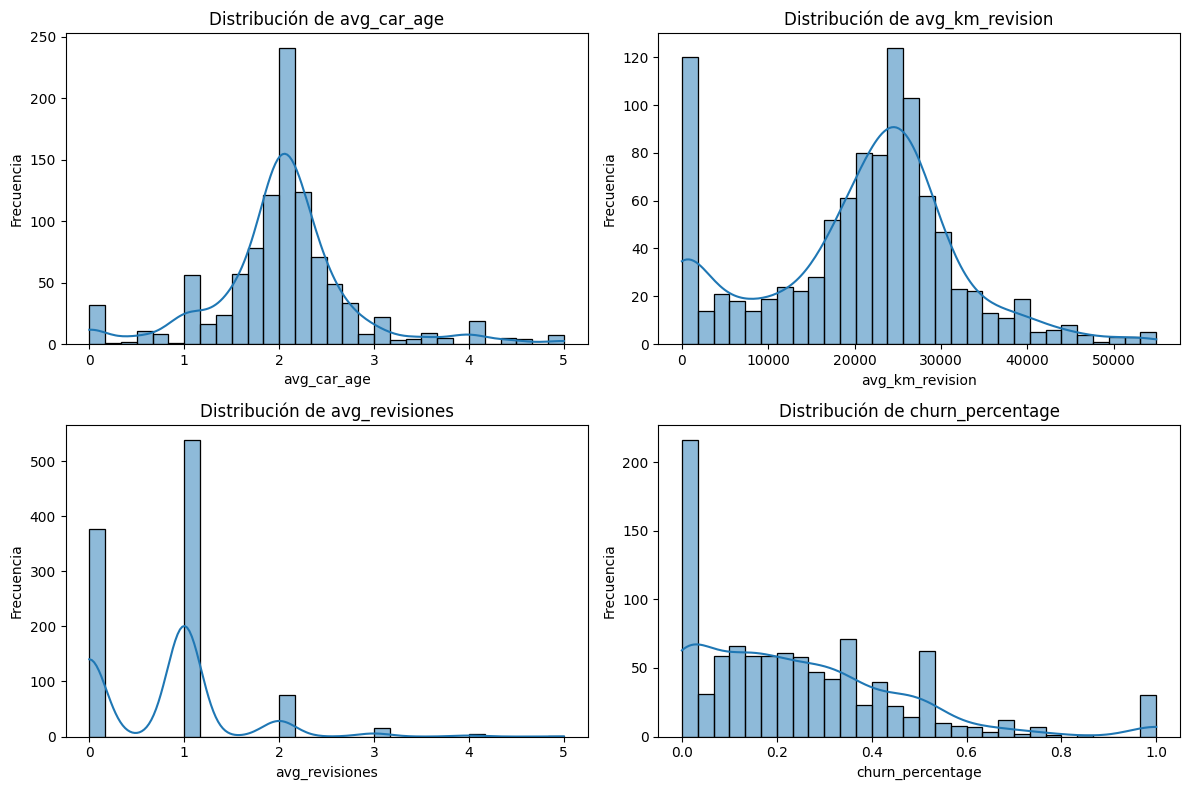

In [100]:
# Histograma de cada variable numérica.
variables = ['avg_car_age', 'avg_km_revision', 'avg_revisiones', 'churn_percentage']

plt.figure(figsize=(12, 8))
for i, col in enumerate(variables, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

**Interpretación de las gráficas.**
- **Edad media del vehículo**: Distribución unimodal y casi simétrica, centrada en torno a los 2 años. Refleja una flota predominantemente reciente, posiblemente por una estrategia comercial enfocada en vehículos nuevos o seminuevos. La presencia de valores cercanos a 0 podría deberse a registros incompletos.
- **Kilometraje medio entre revisiones**: Distribución asimétrica a la derecha, con una concentración significativa por debajo de 10.000 km y una cola prolongada. Sugiere una dualidad entre clientes con revisiones frecuentes y otros con mayor distancia entre mantenimientos, potencialmente más propensos al abandono.
- **Promedio de revisiones por cliente:** Distribución multimodal y marcadamente asimétrica a la derecha, con picos pronunciados en 0 y 1 revisión. Esto indica que una gran parte de los clientes realiza pocas o ninguna revisión, lo cual podría asociarse a un menor compromiso con la marca o menor fidelidad postventa. La cola prolongada hacia la derecha refleja un pequeño grupo de clientes altamente recurrentes en revisiones, posiblemente asociados a contratos de mantenimiento o mayor antigüedad con la marca.

- **Proporción de churn por PVP**: Distribución fuertemente asimétrica a la derecha, con mayoría de valores bajos y una minoría significativa con churn elevado. Este comportamiento respalda el uso de un modelo de regresión, al presentar una variable objetivo continua y dispersa.

### **Relación entre variables independientes y Churn.**
Los siguientes gráficos de dispersión permiten explorar visualmente la relación bivariada entre las variables independientes y la variable objetivo. Esta representación facilita la detección de patrones lineales, efectos no lineales o zonas de saturación, y anticipa la capacidad explicativa de cada variable en el modelo de regresión. Aunque la correlación lineal pueda ser limitada, estas visualizaciones permiten identificar concentraciones de comportamiento, outliers y posibles relaciones estructurales.

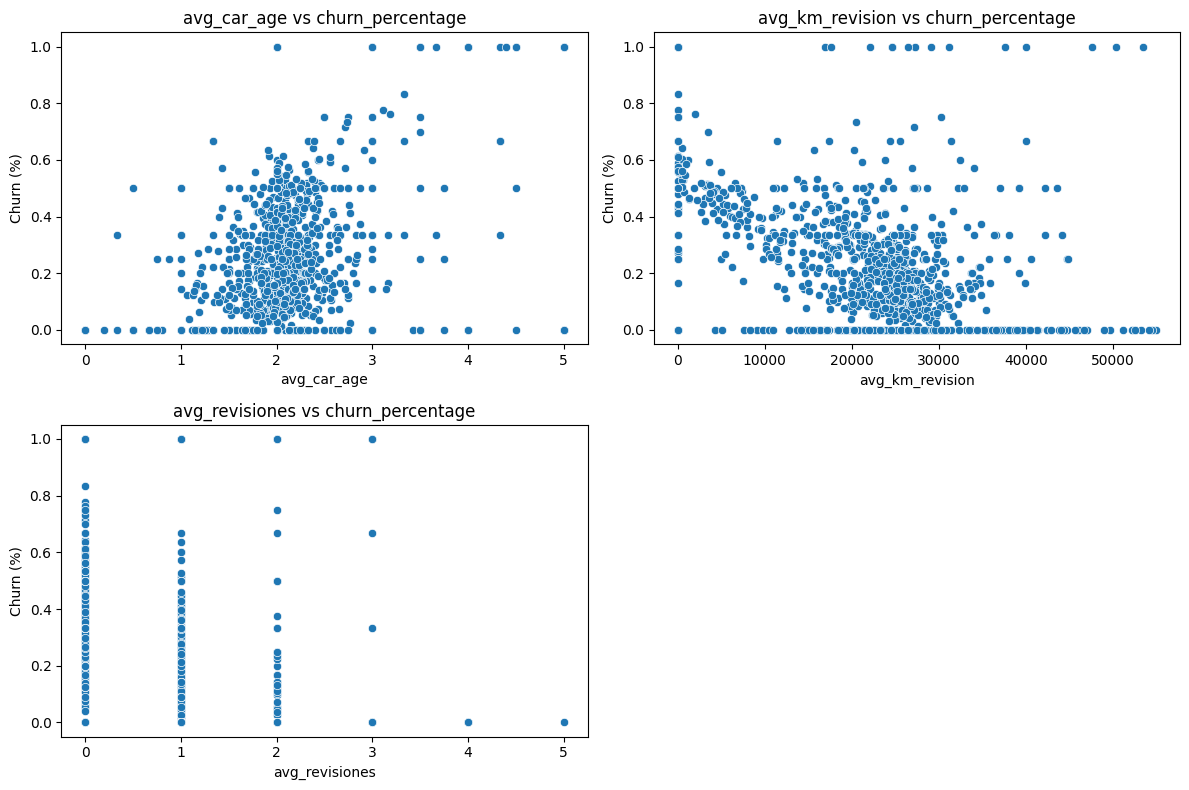

In [101]:
# Gráficos de dispersión para observar patrones lineales.
plt.figure(figsize=(12, 8))
for i, col in enumerate(['avg_car_age', 'avg_km_revision', 'avg_revisiones'], 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df[col], y=df['churn_percentage'])
    plt.title(f'{col} vs churn_percentage')
    plt.xlabel(col)
    plt.ylabel('Churn (%)')
plt.tight_layout()
plt.show()

**Interpretación de las gráficas.**
- **Edad media del vehículo VS Churn**: Relación débilmente dispersa sin tendencia lineal clara. La mayoría de los puntos se concentran entre 1,5 y 2,5 años, con una distribución del churn relativamente homogénea en ese rango. No obstante, se observan algunos casos con churn elevado incluso para edades medias, lo que sugiere que la edad del vehículo podría no ser un predictor determinante por sí solo, aunque podría tener efecto combinado con otras variables.
- **Kilometraje medio entre revisiones VS Churn**: Relación inversa más aparente. Se aprecia una mayor concentración de churn elevado en vehículos con bajos kilómetros entre revisiones (<10.000 km), mientras que a medida que el kilometraje medio aumenta, el churn tiende a disminuir. Este patrón es coherente con un perfil de cliente más vinculado al servicio postventa (revisiones frecuentes = menor churn). La forma decreciente sugiere que esta variable puede tener relevancia predictiva significativa en el modelo.
- **Relación entre revisiones y churn:** Se observa una tendencia decreciente en el churn a medida que aumenta el promedio de revisiones. Los clientes con 0 o 1 revisión presentan los niveles más altos de abandono, mientras que aquellos con 3 o más revisiones prácticamente no churnean. Esta correlación negativa sugiere que una mayor interacción postventa (vía revisiones) puede estar asociada a una mayor fidelidad del cliente. Podría tratarse de un indicador clave para estrategias de retención.

### **Matriz de correlación.**
La matriz de correlación de Pearson permite cuantificar la relación lineal entre las variables del modelo, expresada en un rango de -1 (correlación negativa perfecta) a +1 (correlación positiva perfecta). Este análisis ayuda a identificar variables redundantes, relaciones significativas con la variable dependiente y posibles problemas de colinealidad entre predictores.

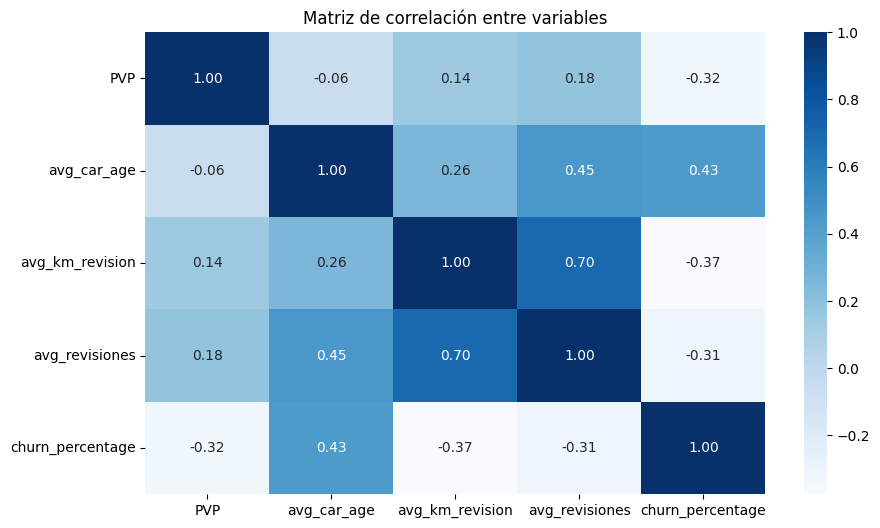

In [102]:
# Matriz de correlación.
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.show()

**Interpretación de las gráficas.**
- **Correlaciones con Churn (Variable Objetivo)**:
  - **Edad media del vehículo** muestra la **mayor correlación positiva** con **Churn**, lo que sugiere que, a mayor edad media del vehículo, aumenta la propensión al abandono. Este resultado refuerza su valor como variable predictiva.
  - **Kilometraje medio entre revisiones** presenta una **correlación negativa moderada**, coherente con la idea de que una mayor frecuencia de revisiones (menor km entre ellas) se asocia a mayor churn.
  - **PVP** mantiene una correlación negativa ligera, indicando que precios más elevados tienden a vincularse con una menor tasa de abandono, aunque el efecto no es dominante.
  - **Revisiones** tiene una **correlación negativa moderada**, igual que **Kilometraje**.

- **Correlaciones entre predictores**: Las correlaciones cruzadas entre variables independientes son bajas, lo cual es **positivo desde el punto de vista de la multicolinealidad**. El mayor valor es entre **Edad media del vehículo** y **Kilometraje medio entre revisiones**, pero no representa un conflicto para la regresión lineal.

## **Modelo de regresión lineal.**
Modelo predictivo construido mediante regresión lineal ordinaria con el objetivo de estimar la variable continua Churn. Las variables explicativas seleccionadas provienen del análisis exploratorio previo y muestran suficiente dispersión y baja colinealidad, lo que permite avanzar con este enfoque interpretativo. El modelo será ajustado sobre el conjunto completo de observaciones, y sus coeficientes se utilizarán posteriormente para proyectar la retención estimada por cliente.

### **Entrenamiento del modelo.**

In [103]:
# Definición de variables predictoras (X) y variable objetivo (y).
X = df[['PVP', 'avg_car_age', 'avg_km_revision', 'avg_revisiones']]
y = df['churn_percentage']

In [104]:
# Entrenamiento del modelo.
model = LinearRegression()
model.fit(X, y)

LinearRegression()

Se generan las predicciones a partir del modelo entrenado. Luego, se aplica una función de clipping para garantizar que los valores predichos se mantengan en el rango lógico **[0, 1]**, ya que se está estimando una proporción o probabilidad. Esto evita la interpretación errónea de valores negativos o superiores al 100%.

In [105]:
# Predicción del Churn.
y_pred = model.predict(X)
y_pred_clipped = np.clip(y_pred, 0, 1)

### **Evaluación del modelo.**
En este bloque se evalúa el rendimiento del modelo de regresión lineal ajustado para predecir el churn estimado (%), y se interpretan los coeficientes obtenidos. Esta información permite analizar la contribución individual de cada variable predictora en el comportamiento del churn.

In [106]:
r2 = r2_score(y, y_pred_clipped)
mse = mean_squared_error(y, y_pred_clipped)
metrics_df = pd.DataFrame({
    'Métrica': ['R² (coef. de determinación)', 'MSE (error cuadrático medio)'],
    'Valor': [r2, mse]
})

print("Evaluación del modelo:")
display(metrics_df)

Evaluación del modelo:


,Métrica,Valor
0,R² (coef. de determinación),0.587018
1,MSE (error cuadrático medio),0.020964


In [107]:
coef_df = pd.DataFrame({
    'Variable': X.columns.tolist() + ['Intercepto'],
    'Coeficiente': model.coef_.tolist() + [model.intercept_]
})

print("Coeficientes estimados:")
display(coef_df)

Coeficientes estimados:


,Variable,Coeficiente
0,PVP,-0.000006
1,avg_car_age,0.200417
2,avg_km_revision,-0.000004
3,avg_revisiones,-0.136655
4,Intercepto,0.187785


**Exportación de coeficientes a SQL Server.** Los coeficientes del modelo se almacenan en la tabla `churn_coef` dentro de SQL Server para facilitar su uso directo desde consultas SQL. Esto permite aplicar el modelo de regresión lineal dentro del entorno de base de datos, integrándolo con vistas como `vision_client`, sin depender del entorno Python.

In [108]:
cursor = conn.cursor()
table = "churn_coef"

# Creación de la tabla.
cursor.execute(f"""
IF NOT EXISTS (SELECT * FROM sysobjects WHERE name='{table}' AND xtype='U')
CREATE TABLE {table} (
    Variable NVARCHAR(50) PRIMARY KEY,
    Coeficiente FLOAT
)
""")

# Vacio de la tabla antes de insertar nuevos coeficientes.
cursor.execute(f"DELETE FROM {table}")

# Inserción de coeficientes en la tabla.
insert_sql = f"INSERT INTO {table} (Variable, Coeficiente) VALUES (?, ?)"
for _, row in coef_df.iterrows():
    cursor.execute(insert_sql, row['Variable'], row['Coeficiente'])

conn.commit()
conn.close()
print(f"Tabla '{table}' creada y poblada correctamente.")

Tabla 'churn_coef' creada y poblada correctamente.


#### **Comparación entre churn real y churn predicho.**
Este gráfico de dispersión representa la relación entre los valores reales de churn y las predicciones generadas por el modelo de regresión lineal múltiple. Su propósito es proporcionar una evaluación visual del grado de ajuste del modelo.

Se aprecia una tendencia creciente, lo que indica que el modelo es capaz de capturar parcialmente la dirección del fenómeno. No obstante, la dispersión de los puntos alrededor de la diagonal sugiere que existe una variabilidad significativa no explicada por el modelo, especialmente en los extremos del rango.

La mayor concentración de observaciones en valores bajos de churn refleja la distribución real de la variable objetivo, pero también pone de manifiesto una ligera tendencia del modelo a sobreestimar en esos casos. Este tipo de visualización resulta especialmente útil para identificar posibles sesgos sistemáticos en las predicciones y evaluar la consistencia del modelo a lo largo de todo el dominio de la variable dependiente.

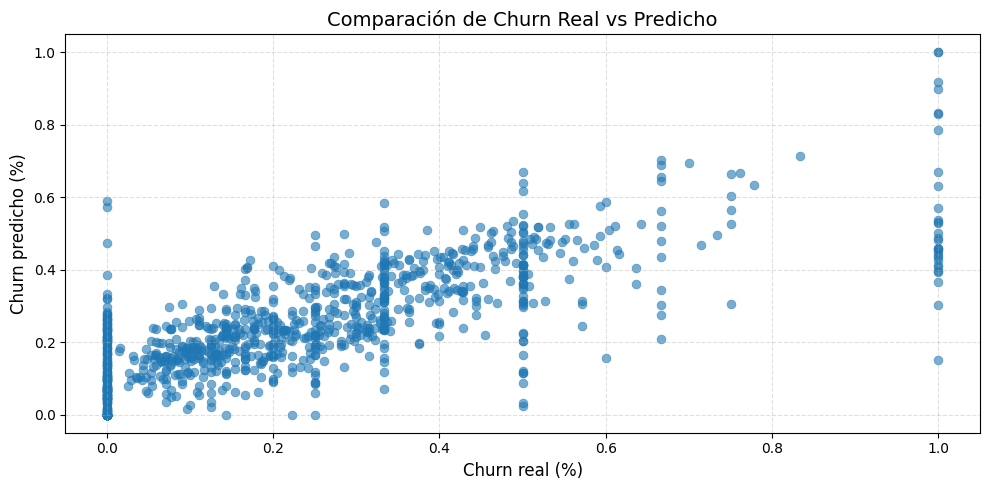

In [109]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y, y=y_pred_clipped, alpha=0.6, s=40, edgecolor=None)

plt.xlabel("Churn real (%)", fontsize=12)
plt.ylabel("Churn predicho (%)", fontsize=12)
plt.title("Comparación de Churn Real vs Predicho", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()